In [23]:
#@title run
%%capture
!rm -rf bills_photos/ __MACOSX/
!curl -vLJO -H 'Accept: application/octet-stream' https://api.github.com/repos/romellfudi/bills_tf_android/releases/assets/26118074  -u "contactboosttag:254aa92f4c88b57bdbc42070fbd0c66e58d00121" 
!unzip bills_photos.zip
!find . -name '*.xml' -delete
%cd /content/

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [25]:
# Organize data into train, valid, test dirs
os.chdir('bills_photos')
if os.path.isdir('train/10') is False:
    os.makedirs('train/10')
    os.makedirs('train/20')
    os.makedirs('train/50')
    os.makedirs('train/100')
    os.makedirs('valid/10')
    os.makedirs('valid/20')
    os.makedirs('valid/50')
    os.makedirs('valid/100')
    os.makedirs('test/10')
    os.makedirs('test/20')
    os.makedirs('test/50')
    os.makedirs('test/100')

    for i in random.sample(glob.glob('Billetes 10/*.JPG'), 120):
        shutil.move(i, 'train/10')      
    for i in random.sample(glob.glob('Billetes 20/*.JPG'), 120):
        shutil.move(i, 'train/20')   
    for i in random.sample(glob.glob('Billetes 50/*.JPG'), 120):
        shutil.move(i, 'train/50')   
    for i in random.sample(glob.glob('Billetes 100/*.JPG'), 120):
        shutil.move(i, 'train/100')
    for i in random.sample(glob.glob('Billetes 10/*.JPG'), 60):
        shutil.move(i, 'valid/10')   
    for i in random.sample(glob.glob('Billetes 20/*.JPG'), 60):
        shutil.move(i, 'valid/20')   
    for i in random.sample(glob.glob('Billetes 50/*.JPG'), 60):
        shutil.move(i, 'valid/50')        
    for i in random.sample(glob.glob('Billetes 100/*.JPG'), 60):
        shutil.move(i, 'valid/100')
    for i in random.sample(glob.glob('Billetes 10/*.JPG'), 20):
        shutil.move(i, 'test/10')  
    for i in random.sample(glob.glob('Billetes 20/*.JPG'), 20):
        shutil.move(i, 'test/20')  
    for i in random.sample(glob.glob('Billetes 50/*.JPG'), 20):
        shutil.move(i, 'test/50')      
    for i in random.sample(glob.glob('Billetes 100/*.JPG'), 20):
        shutil.move(i, 'test/100')

os.chdir('../')

In [26]:
#@title Show cores
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [27]:
train_path = 'bills_photos/train'
valid_path = 'bills_photos/valid'
test_path = 'bills_photos/test'

In [28]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['10', '20', '50', '100'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['10', '20', '50', '100'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['10', '20', '50', '100'], batch_size=10, shuffle=False)

Found 480 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [29]:
imgs, labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

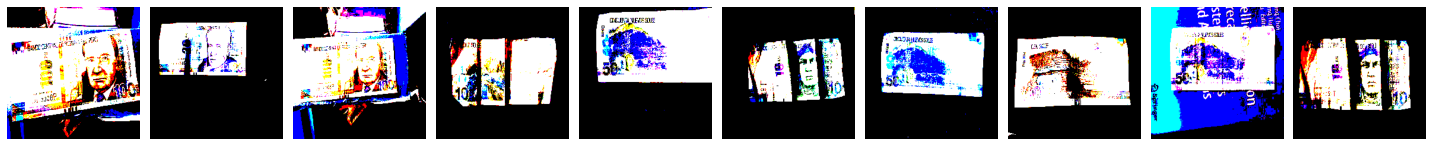

[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


In [30]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(imgs)
print(labels)

In [32]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=4, activation='softmax')
])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 802820    
Total params: 822,212
Trainable params: 822,212
Non-trainable params: 0
________________________________________________

In [34]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
48/48 - 4s - loss: 53.9253 - accuracy: 0.4729 - val_loss: 11.1163 - val_accuracy: 0.6167
Epoch 2/10
48/48 - 4s - loss: 2.1838 - accuracy: 0.8562 - val_loss: 2.0806 - val_accuracy: 0.8458
Epoch 3/10
48/48 - 4s - loss: 0.5485 - accuracy: 0.9396 - val_loss: 2.1505 - val_accuracy: 0.8583
Epoch 4/10
48/48 - 4s - loss: 0.2548 - accuracy: 0.9667 - val_loss: 1.6083 - val_accuracy: 0.8875
Epoch 5/10
48/48 - 4s - loss: 0.6223 - accuracy: 0.9438 - val_loss: 2.1720 - val_accuracy: 0.8875
Epoch 6/10
48/48 - 4s - loss: 0.1002 - accuracy: 0.9875 - val_loss: 2.0983 - val_accuracy: 0.8958
Epoch 7/10
48/48 - 4s - loss: 0.0323 - accuracy: 0.9937 - val_loss: 2.6634 - val_accuracy: 0.8417
Epoch 8/10
48/48 - 4s - loss: 0.0629 - accuracy: 0.9917 - val_loss: 1.6617 - val_accuracy: 0.9208
Epoch 9/10
48/48 - 4s - loss: 0.2403 - accuracy: 0.9792 - val_loss: 3.6193 - val_accuracy: 0.7958
Epoch 10/10
48/48 - 4s - loss: 0.1635 - accuracy: 0.9812 - val_loss: 2.7323 - val_accuracy: 0.8625


In [36]:
test_imgs, test_labels = next(test_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

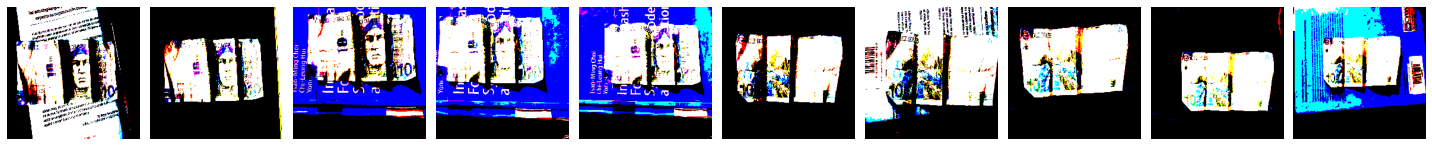

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [37]:
plotImages(test_imgs)
print(test_labels)

In [38]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [39]:
np.round(predictions)

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],


In [40]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [42]:
test_batches.class_indices

{'10': 0, '100': 3, '20': 1, '50': 2}

Confusion matrix, without normalization
[[14  1  2  3]
 [ 0 20  0  0]
 [ 0  1 19  0]
 [ 0  3  0 17]]


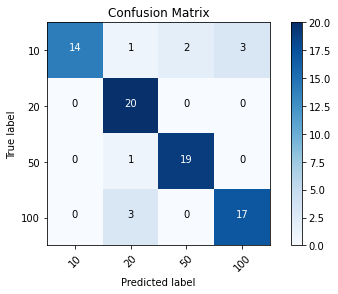

In [44]:
cm_plot_labels = ['10','20','50','100']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')